In [1]:
import re
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.special import gammaln

# import edward2 as ed

from sklearn.datasets import fetch_20newsgroups

from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string, stem_text
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel

from tqdm.notebook import tqdm as tqdm

[nltk_data] Downloading package wordnet to /home/iron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data download

In [2]:
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

### Data sampling

In [3]:
seed = 42
np.random.seed(seed)

In [4]:
N = 1000

data = pd.Series(data_train.data).sample(N)
data.reset_index(drop=True, inplace=True)

In [5]:
data.head(5)

0    From: rrn@po.CWRU.Edu (Robert R. Novitskey)\nS...
1    From: ardie@ux1.cso.uiuc.edu (Ardie Mack)\nSub...
2    From: tsa@cellar.org (The Silent Assassin)\nSu...
3    From: guy@idacom.hp.com (Guy M. Trotter)\nSubj...
4    From: jwodzia@fadel.uucp (john wodziak)\nSubje...
dtype: object

In [6]:
data.iloc[0]

'From: rrn@po.CWRU.Edu (Robert R. Novitskey)\nSubject: CYCLONE AND TEMPEST?????\nArticle-I.D.: usenet.1pskav$qtu\nReply-To: rrn@po.CWRU.Edu (Robert R. Novitskey)\nOrganization: Case Western Reserve University, Cleveland, OH (USA)\nLines: 10\nNNTP-Posting-Host: thor.ins.cwru.edu\n\n\nCould someone please post any info on these systems.\n\nThanks.\nBoB\n-- \n---------------------------------------------------------------------- \nRobert Novitskey | "Pursuing women is similar to banging one\'s head\nrrn@po.cwru.edu  |  against a wall...with less opportunity for reward" \n---------------------------------------------------------------------- \n'

### Data preprocessing

In [7]:
clean_stem_filters = [strip_tags,
                        strip_numeric,
                        strip_punctuation, 
                        lambda x: x.lower(),
                        lambda s: re.sub(r'\b\w{1,2}\b', ' ', s),
                        strip_multiple_whitespaces,
                        remove_stopwords
                     ]

def text_processing(document):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(i) for i in preprocess_string(document, clean_stem_filters)]

In [8]:
data = data.apply(text_processing)

In [9]:
" ".join(data.iloc[0])

'rrn cwru edu robert novitskey subject cyclone tempest article usenet pskav qtu reply rrn cwru edu robert novitskey organization case western reserve university cleveland usa line nntp posting host thor in cwru edu post info system thanks bob robert novitskey pursuing woman similar banging head rrn cwru edu wall opportunity reward'

In [10]:
data_dict = Dictionary(data)

In [11]:
print("# docs: {}, # words: {}".format(data_dict.num_docs, data_dict.num_pos))

# docs: 1000, # words: 137785


### Model definition

In [12]:
class LDAGibbs():
    def __init__(self, docs, K, alpha_prior=0.5, eta_prior=0.5, random_seed=None):
        np.random.seed(random_seed)
        
        self.K = K
        self.alpha_p = alpha_prior
        self.eta_p = eta_prior

        self.data = docs
        self.data_dict = Dictionary(self.data)
        self.Nd = [len(d) for d in data.values]
        
        self.n_docs = self.data_dict.num_docs
        self.n_words = len(self.data_dict.keys())
        
        # Number of words in document d assigned to topic k
        self.n_kd = np.zeros((self.K, self.n_docs))

        # Number of times topic k is assigned to term v
        self.n_kv = sparse.coo_matrix((self.K, self.n_words),
            dtype=np.uint32
        )

        self.n_kv = self.n_kv.tolil()

        # Number of words assigned to topic k 
        self.n_k = np.zeros((K,))

        # Topic assignments per document to term v
        self.k_dw = sparse.coo_matrix((self.n_docs, self.n_words),
            dtype=np.uint32
        )

        self.k_dw = self.k_dw.tolil()


        # Total number of times topic k was assigned to word w
        self.total_nkv = sparse.coo_matrix((self.K, self.n_words),
            dtype=np.uint32
        )

        self.total_nkv = self.total_nkv.tolil()

        # Total number of times topic k was assigned to document d
        self.total_nkd = np.zeros((self.K, self.n_docs))

        for d in range(self.n_docs):
            for w in data[d]:
                k = np.random.randint(self.K)
                self.n_k[k] += 1
                self.n_kv[k, self.data_dict.token2id[w]] += 1
                self.n_kd[k, d] += 1
                self.k_dw[d, self.data_dict.token2id[w]] = k

    def fit(self, max_iterations=1000, burnin=100, sample_every_n_iter=25):
        self.ll = []
        self.pp = []
        self.cc = []
        
        if burnin > 0:
            print("Beginning burn-in phase")

            for i in tqdm(range(burnin)):
                self._sweep()

        print("Beginning sampling phase")

        self.ll = []
        self.pp = []
        self.cc = []
        for i in tqdm(range(1, max_iterations+1)):
            self._sweep()

            if i % sample_every_n_iter == 0:
                self.total_nkv += self.n_kv
                self.total_nkd += self.n_kd

                this_ll = self.loglikelihood()
                this_pp = self.get_perplexity()
                this_cc = self.get_coherence('c_v')
                print("Log-likelihood:", this_ll, "- Perplexity:", this_pp, "- Coherence:", this_cc)

                self.ll.append(this_ll)
                self.pp.append(this_pp)
                self.cc.append(this_cc)

        print("Done.")

    def loglikelihood(self):
        llk = 0
        for k in range(self.K):
            nkv = self.n_kv[k,:].toarray()[0]
            llk += np.sum(gammaln(nkv + self.eta_p)) - gammaln(np.sum(nkv + self.eta_p))
            llk -= self.n_words * gammaln(self.eta_p) - gammaln(self.n_words * self.eta_p)

        for d in range(self.n_docs):
            llk += np.sum(gammaln(self.n_kd[:, d] + self.alpha_p)) - gammaln(np.sum(self.n_kd[:, d] + self.alpha_p))
            llk -= self.K * gammaln(self.alpha_p) - gammaln(self.K * self.alpha_p)

        return llk

    def phi(self):
        phi = self.total_nkv.toarray() + self.eta_p
        return np.swapaxes(phi / np.sum(phi, axis=0)[np.newaxis, :], 0, 1)

    def theta(self):
        theta = self.total_nkd + self.alpha_p
        return np.swapaxes(theta / np.sum(theta, axis=0)[np.newaxis, :], 0, 1)
    
    def get_topics(self):
        topics = []
        for top_10_k in np.swapaxes(self.phi().argsort(axis=0)[-10:, :], 0, 1):
            topics.append([self.data_dict[w] for w in top_10_k])

        return topics

    def get_coherence(self, coherence_type='c_v'):
        coherence_model_lda = CoherenceModel(topics=self.get_topics(), texts=self.data, dictionary=self.data_dict, coherence='c_v')
        return coherence_model_lda.get_coherence()


    def get_perplexity(self):
        return np.exp(-self.loglikelihood()/sum(self.Nd))
    
    def _sample_conditional(self, d, w):
        probs = (self.n_kd[:, d] + self.alpha_p)
#         probs /= (self.K * self.alpha_p + self.Nd[d])
        probs *= (self.n_kv[:, data_dict.token2id[w]].toarray().reshape(1,-1)[0] + self.eta_p) 
        probs /= (self.eta_p * self.n_words + self.n_k)
        probs /= probs.sum()
        return np.random.choice(range(K), p=probs)

    def _sweep(self):
        docs = list(range(self.n_docs))
        np.random.shuffle(docs)
        for d in docs:
            for w in self.data[d]:
                k = self.k_dw[d, self.data_dict.token2id[w]]
                self.n_k[k] -= 1
                self.n_kv[k, self.data_dict.token2id[w]] -= 1
                self.n_kd[k, d] -= 1

                new_k = self._sample_conditional(d, w)

                self.k_dw[d, self.data_dict.token2id[w]] = new_k
                self.n_k[new_k] += 1
                self.n_kv[new_k, self.data_dict.token2id[w]] += 1
                self.n_kd[new_k, d] += 1

        return


### Execution

In [19]:
K = 10

# Priors
eta_p = 0.1
alpha_p = 0.01

max_iterations = 1000
burn_in_iter = 25

sample_every_n_iter = 25

lda = LDAGibbs(data, K, alpha_prior=alpha_p, eta_prior=eta_p, random_seed=42)

lda.fit(max_iterations=max_iterations, burnin=burn_in_iter, sample_every_n_iter=sample_every_n_iter)

Beginning burn-in phase


  0%|          | 0/25 [00:00<?, ?it/s]

Beginning sampling phase


  0%|          | 0/1000 [00:00<?, ?it/s]

Log-likelihood: -1512834.8913426246 - Perplexity: 58669.64176645961 - Coherence: 0.5846592796019917
Log-likelihood: -1511527.7302749895 - Perplexity: 58115.676977175586 - Coherence: 0.5854564258543763
Log-likelihood: -1511386.7327544752 - Perplexity: 58056.23672476789 - Coherence: 0.5909868475859137
Log-likelihood: -1510957.9850158223 - Perplexity: 57875.86300669332 - Coherence: 0.5080326517828214
Log-likelihood: -1510262.9790873986 - Perplexity: 57584.664469289935 - Coherence: 0.4893656123979044
Log-likelihood: -1509872.2481204614 - Perplexity: 57421.597090152565 - Coherence: 0.4758533737079569
Log-likelihood: -1510227.0570764681 - Perplexity: 57569.65349333063 - Coherence: 0.5130140542653806
Log-likelihood: -1510193.9516743019 - Perplexity: 57555.822977745454 - Coherence: 0.4966553712493142
Log-likelihood: -1510463.8869775604 - Perplexity: 57668.69141148788 - Coherence: 0.4733726289057477
Log-likelihood: -1510332.062970866 - Perplexity: 57613.54402600743 - Coherence: 0.47457248632039

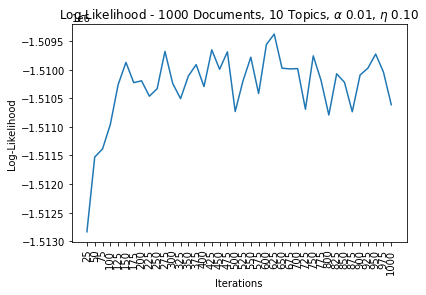

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = range(sample_every_n_iter, max_iterations+1, sample_every_n_iter)
ax.plot(x, lda.ll)
ax.set_xlabel("Iterations")
ax.set_xticks(x)
ax.set_ylabel("Log-Likelihood")

ax.set_title("Log-Likelihood - {} Documents, {} Topics, $\\alpha$ {:.2f}, $\\eta$ {:.2f}".format(
    lda.n_docs, K, alpha_p, eta_p
    )
)

ax.set_xticklabels(x, rotation = 90)

fig.savefig("results/timeVsLogLikelihood-d{}t{}i{}b{}alpha{}eta{}.pdf".format(lda.n_docs, K, max_iterations, burn_in_iter, alpha_p, eta_p))


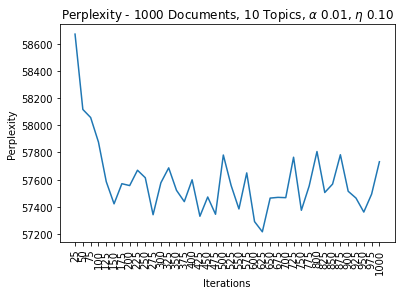

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = range(sample_every_n_iter, max_iterations+1, sample_every_n_iter)
ax.plot(x, lda.pp)
ax.set_xlabel("Iterations")
ax.set_xticks(x)
ax.set_ylabel("Perplexity")

ax.set_title("Perplexity - {} Documents, {} Topics, $\\alpha$ {:.2f}, $\\eta$ {:.2f}".format(
    lda.n_docs, K, alpha_p, eta_p
    )
)

ax.set_xticklabels(x, rotation = 90)

fig.savefig("results/timeVsPerplexity-d{}t{}i{}b{}alpha{}eta{}.pdf".format(lda.n_docs, K, max_iterations, burn_in_iter, alpha_p, eta_p))


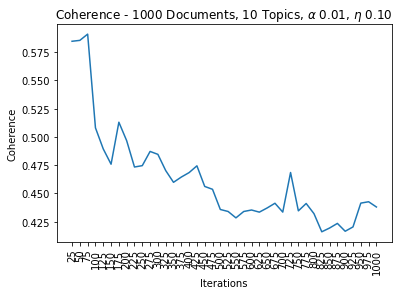

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = range(sample_every_n_iter, max_iterations+1, sample_every_n_iter)
ax.plot(x, lda.cc)
ax.set_xlabel("Iterations")
ax.set_xticks(x)
ax.set_ylabel("Coherence")

ax.set_title("Coherence - {} Documents, {} Topics, $\\alpha$ {:.2f}, $\\eta$ {:.2f}".format(
    lda.n_docs, K, alpha_p, eta_p
    )
)

ax.set_xticklabels(x, rotation = 90)

fig.savefig("results/timeVsCoherence-d{}t{}i{}b{}alpha{}eta{}.pdf".format(lda.n_docs, K, max_iterations, burn_in_iter, alpha_p, eta_p))


In [23]:
topics = lda.get_topics()
str_ = ""
for id_, topic in enumerate(topics):
    str_ += str(id_+1) + ". "
    for w in topic[:-1]:
        str_ += w + ", "
    str_ += topic[-1] + "\n"

with open("results/topics-d{}t{}i{}b{}alpha{}eta{}.txt".format(lda.n_docs, K, max_iterations, burn_in_iter, alpha_p, eta_p), "w+") as f:
    f.write(str_)


In [24]:
for t in topics:
    print(t)

['brante', 'rhodes', 'horton', 'cmich', 'cmuvm', 'clifford', 'tsa', 'krumreich', 'shograf', 'shorwave']
['infectious', 'ccfa', 'programarea', 'shouse', 'trait', 'pretense', 'keefe', 'vccsouth', 'spartan', 'binah']
['rabbit', 'pilate', 'sexton', 'xcopyarea', 'pef', 'desperate', 'slagel', 'mully', 'mullin', 'compaq']
['jade', 'kay', 'unisql', 'apgea', 'in', 'rclar', 'nazario', 'prey', 'kbas', 'frip']
['oncologist', 'guild', 'datman', 'xsendevent', 'dictating', 'cookamunga', 'prozac', 'davidians', 'alink', 'ksand']
['bultman', 'overlapped', 'cwj', 'eqh', 'silbiger', 'keren', 'tutor', 'pe', 'tscs', 'rupin']
['zoology', 'wpafb', 'relativists', 'oryx', 'chastity', 'cadre', 'dsl', 'njxp', 'skepticism', 'intellect']
['ghasting', 'princeton', 'mackie', 'babb', 'andersson', 'gilbert', 'unexpected', 'tamamen', 'maler', 'isgal']
['marxism', 'charlap', 'epstein', 'runyon', 'bert', 'ryukoku', 'hind', 'colon', 'cotter', 'luong']
['lif', 'stalker', 'gvg', 'ramarren', 'faraday', 'berk', 'clas', 'swaim'